In [1]:
import numpy as np
import pandas as pd
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

from features.data_provider import get_train_test_wc_dataset, get_feature_columns, get_whole_dataset
from models.grid_search import run_custom_grid_search
from models.helpers import get_best_params, get_feature_importance

In [2]:
X_train, y_train, X_test, y_test, X_wc, y_wc = get_train_test_wc_dataset("home_win")

<Figure size 1440x432 with 0 Axes>

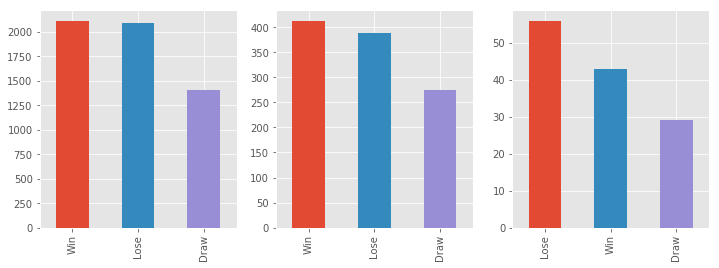

In [3]:
def get_labeled_df(s):
    df = pd.DataFrame(s)
    df[df["home_win"] == 1] = "Win"
    df[df["home_win"] == 0] = "Draw"
    df[df["home_win"] == -1] = "Lose"
    return df

plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
pd.value_counts(get_labeled_df(y_train)["home_win"]).plot.bar(ax=axes[0])
pd.value_counts(get_labeled_df(y_test)["home_win"]).plot.bar(ax=axes[1])
pd.value_counts(get_labeled_df(y_wc)["home_win"]).plot.bar(ax=axes[2])

In [4]:
params = {"oob_score":True, "bootstrap":True, "n_jobs":-1, "n_estimators": 5000} 
results = run_custom_grid_search(params, X_train, y_train, X_test, y_test, X_wc, y_wc, classifier=True)
get_best_params(results)

Parameter estimation took:  792.1177401542664


{'max_depth': 5.0, 'max_features': 'log2', 'min_samples_leaf': 1}

In [5]:
results

,max_depth,max_features,min_samples_leaf,test_acc,test_mae,test_mse,train_acc,train_mae,train_mse,wc_acc,wc_mae,wc_mse,best_combo
0,3.0,sqrt,1,0.536744,0.671628,1.088372,0.547938,0.653812,1.057311,0.578125,0.617188,1.007812,1.114869
1,3.0,log2,1,0.533953,0.677209,1.099535,0.547938,0.653812,1.057311,0.578125,0.617188,1.007812,1.112078
2,3.0,sqrt,3,0.535814,0.673488,1.092093,0.549009,0.651669,1.053026,0.578125,0.617188,1.007812,1.113939
3,3.0,log2,3,0.534884,0.675349,1.095814,0.547938,0.653812,1.057311,0.578125,0.617188,1.007812,1.113009
4,3.0,sqrt,5,0.535814,0.673488,1.092093,0.549009,0.651669,1.053026,0.578125,0.617188,1.007812,1.113939
5,3.0,log2,5,0.535814,0.673488,1.092093,0.547581,0.654526,1.058740,0.578125,0.617188,1.007812,1.113939
6,3.0,sqrt,10,0.535814,0.673488,1.092093,0.548473,0.652741,1.055169,0.578125,0.617188,1.007812,1.113939
7,3.0,log2,10,0.534884,0.675349,1.095814,0.547581,0.654526,1.058740,0.578125,0.617188,1.007812,1.113009
8,3.0,sqrt,15,0.536744,0.671628,1.088372,0.547938,0.653812,1.057311,0.578125,0.617188,1.007812,1.114869
9,3.0,log2,15,0.533953,0.677209,1.099535,0.547938,0.653812,1.057311,0.578125,0.617188,1.007812,1.112078
